In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

In [2]:
# Set seed for determinism
np.random.seed(0)

In [3]:
# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

In [4]:
X_train.shape

(100, 275, 1)

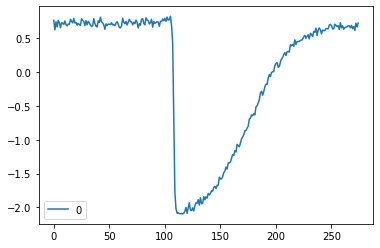

In [5]:
pd.DataFrame(X_train[1]).plot.line();

In [6]:
# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

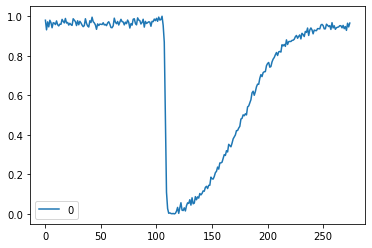

In [7]:
pd.DataFrame(X_train[1]).plot.line();

In [8]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

In [9]:
X_train.shape[:2]

(100, 275)

In [10]:
n_classes

4

In [11]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,    # number of timeseries in dataset
                                                       ts_sz=ts_sz,  # length of timeseries in dataset
                                                       n_classes=n_classes,
                                                       l=0.1,  # Fraction of length of timeseries to be used for base shapelet length
                                                       r=1)  # Number of different shapelet lengths to use

In [12]:
shapelet_sizes

{27: 4}

In [13]:
# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)
shp_clf.fit(X_train, y_train)

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(batch_size=16, max_iter=200, n_shapelets_per_size={27: 4},
                  optimizer=<keras.optimizer_v2.adam.Adam object at 0x0000018247B7CAF0>,
                  random_state=42, weight_regularizer=0.01)

In [14]:
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

Correct classification rate: 1.0


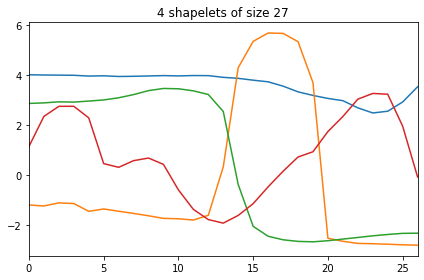

In [15]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

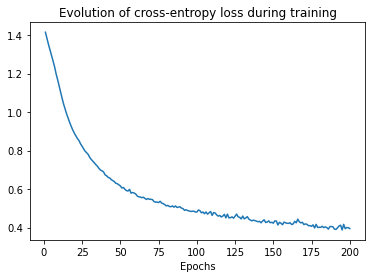

In [16]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()